# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook 7 - Building an ensemble and testing

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

In this workbook we're choosing the right ML algorithms based on cross validation, building an ensemple and testing it.

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..')
sys.path.append(path_to_project)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from multiprocessing import cpu_count
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
import WQUcapstoneCode.ml.ml as wqu
#from WQUcapstoneCode.ml.ml import cv_with_custom_score, train_valid_test_split, get_pyfolio_simple_tear_sheet

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [5]:
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [6]:
tickers = ['AUD/USD','AUD/CAD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']

Below we calculate feature inportance based on Random Forest, and then teach a number of ML algorythms using different sets of features.

In [7]:
RANDOM_STATE = 1
score_dict = {}
rtn_dict = {}
sharp_dict = {}
n_splits = 4

models = {'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
          'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   

for ticker in tickers:
    score_dict[ticker] = {}
    sharp_dict[ticker] = {}
    rtn_dict[ticker] = {}
    d = dt.datetime.now().strftime('%I:%M%p')
    print(f'{d}: Cross-validating on {ticker}')
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)
    
    # splitting the data   
    X_train, Y_train, target_rtns_train \
    , X_valid, Y_valid, target_rtns_valid, _, _, _ = wqu.train_valid_test_split(data,'50:25:25')
    
    # here we use all training set to calculate feature importances, which is a cheat because later part of cross validated set becomes validation set. However, is was found that features are relatively stable across subsets. In any case, the result will be tested using validation set
    all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train, models['Tuned RF'])
    
    features = {'all_feature_cols':all_feature_cols, 
                'ex_frdiff_cols':ex_frdiff_cols,
                'frdiff_cols':frdiff_cols,
                'top_feat_RF': top_feat
               }
    
    cv = KFold(n_splits=n_splits, shuffle=False)
    # cross validating all algorythms
    for n,cols in features.items():
        score_dict[ticker][n] = {}
        sharp_dict[ticker][n] = {}
        rtn_dict[ticker][n] = {}
        for m,c in models.items():
            n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')           
            r, sh = wqu.cv_with_custom_score(c, X_train[cols], Y_train, target_rtns_train, n_folds=n_splits)
            rtn_dict[ticker][n][m] = r
            score_dict[ticker][n][m] = np.mean(n_scores)
            sharp_dict[ticker][n][m] = sh

12:46PM: Cross-validating on AUD/USD
12:49PM: Cross-validating on AUD/CAD
12:51PM: Cross-validating on AUD/JPY
12:52PM: Cross-validating on EUR/USD
12:54PM: Cross-validating on GBP/USD
12:56PM: Cross-validating on NZD/USD
12:58PM: Cross-validating on USD/CAD
01:00PM: Cross-validating on USD/JPY


In [9]:
#generation of the data takes ~10min, for for testing purposes it makes sense to save results
pickle_path = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path, 'wb') as output_file:
    pickle.dump({'returns':rtn_dict, 'accuracy': score_dict, 'sharp': sharp_dict},
                output_file)

In [7]:
pickle_path = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path, "rb") as input_file:
    d = pickle.load(input_file)
    rtn_dict = d['returns']
    score_dict = d['accuracy']
    sharp_dict = d['sharp']

Now that we have score_dict, rtn_dict and sharp_dict objects, we can slice and dice them. We can either select the algorythms that perform better on average on all currency pairs, or we can use the best algorythms for a selected currency pair.
Please see below the average characteristics of algorythms.

### Accuracy map

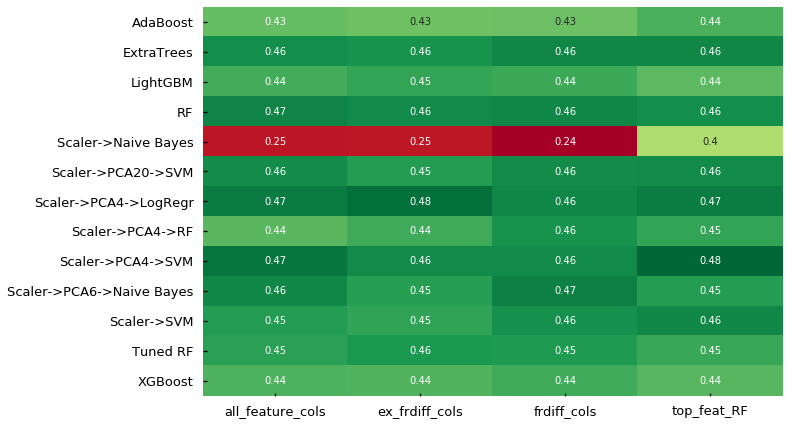

In [8]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in score_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

### Sharp ratios

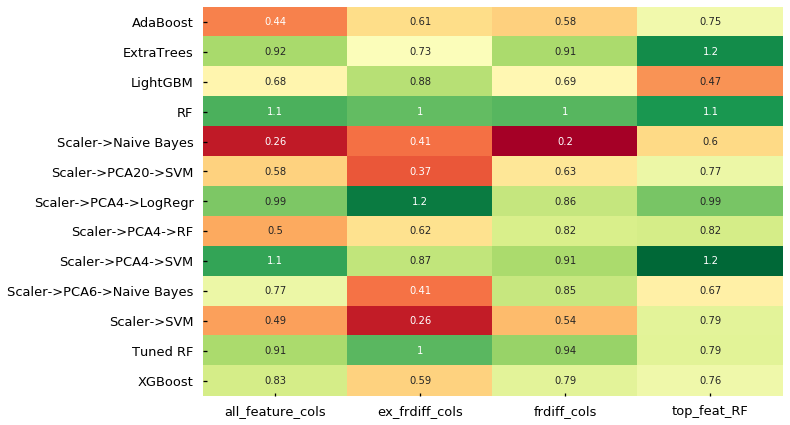

In [10]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in sharp_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

### Returns and standard deviation of returns across currency pairs

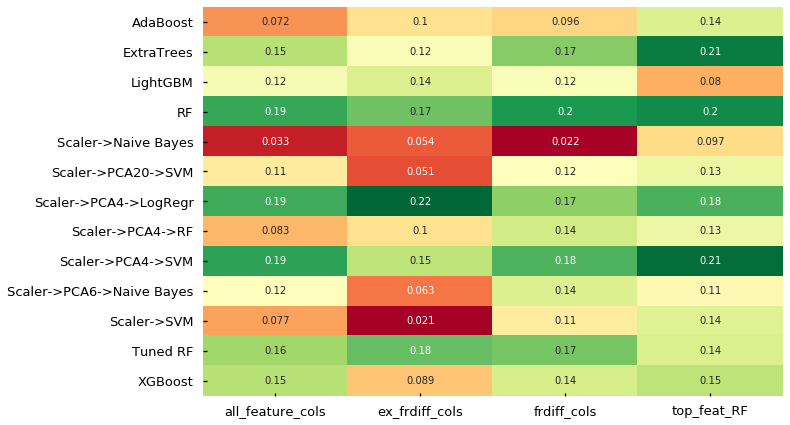

In [11]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in rtn_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

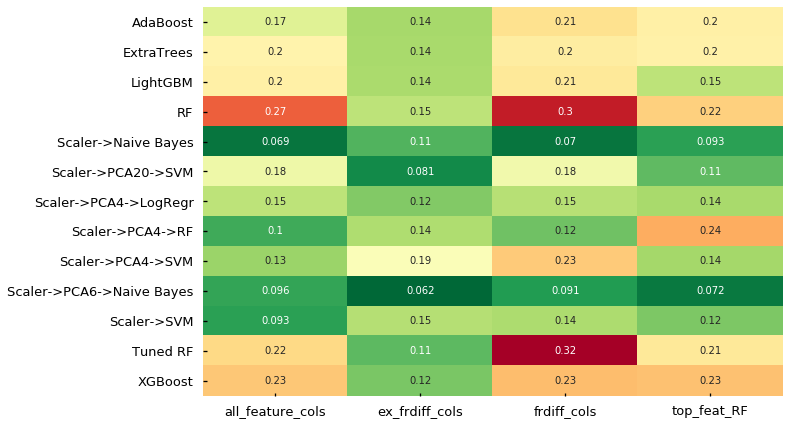

In [12]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in rtn_dict.items()]).groupby(level=0).std(),
            annot=True, cbar=False, cmap="RdYlGn_r")

Accuracy scores are relatively the same except for Naive Bayes. 
We see that using features selected by Random Forest helps to increase returns and sharp ratio. 
On average, Extra Trees, Random Forest, PCA4->Logistic Regression and PCA4->SVA perform better.

## Testing on validation sets

In [79]:
#tickers = ['AUD/USD','AUD/CAD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']
ticker = 'AUD/USD'
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)
# splitting the data   
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')
all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [37]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

Start date,2017-06-02
End date,2019-01-04
Total months,11
,Backtest
Annual return,0.285%
Cumulative returns,0.268%
Annual volatility,10.061%
Sharpe ratio,0.08
Calmar ratio,0.03
Stability,0.63
Max drawdown,-10.783%


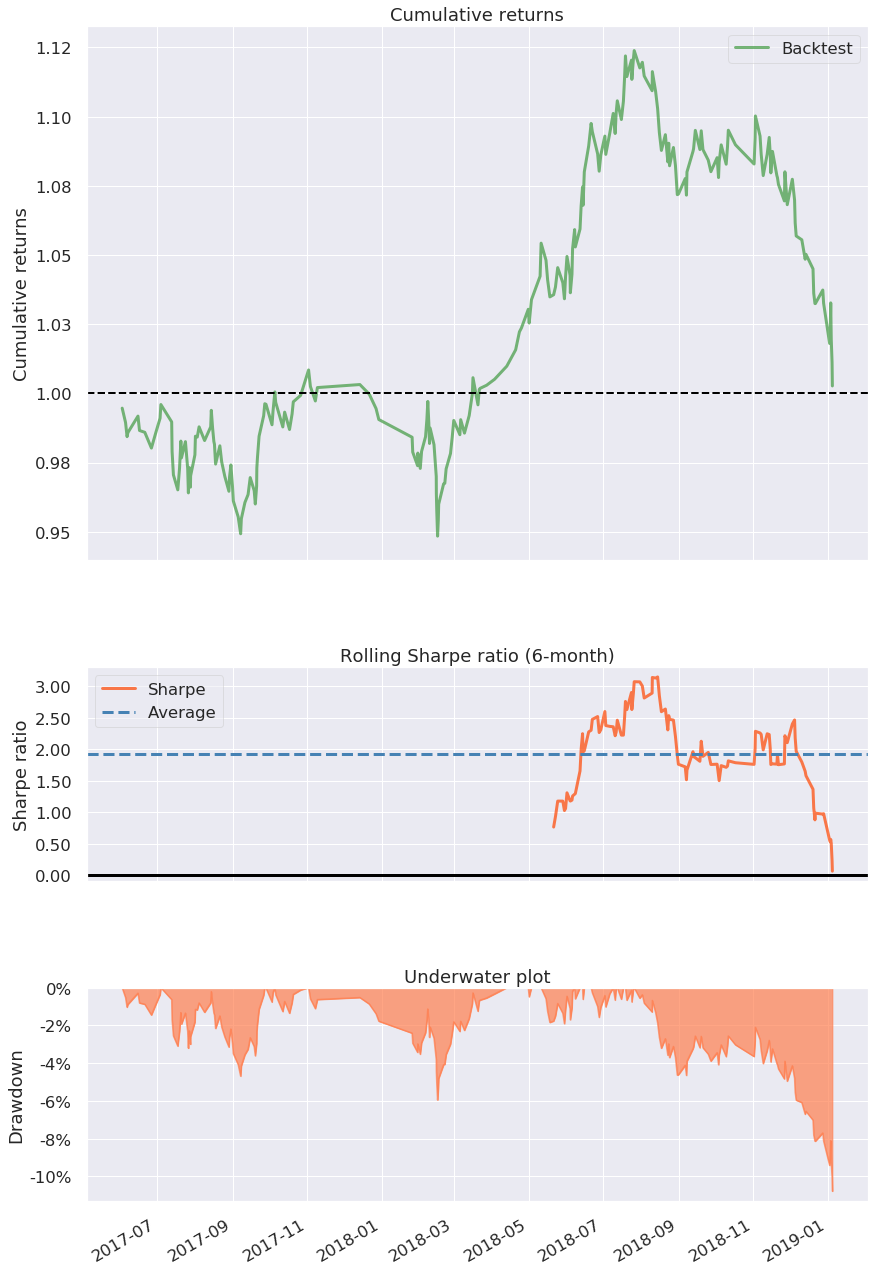

In [38]:
model = 'RF'
cols = top_feat
validation = True
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

Start date,2017-06-02
End date,2019-01-04
Total months,11
,Backtest
Annual return,7.312%
Cumulative returns,6.862%
Annual volatility,10.05%
Sharpe ratio,0.75
Calmar ratio,1.05
Stability,0.77
Max drawdown,-6.995%


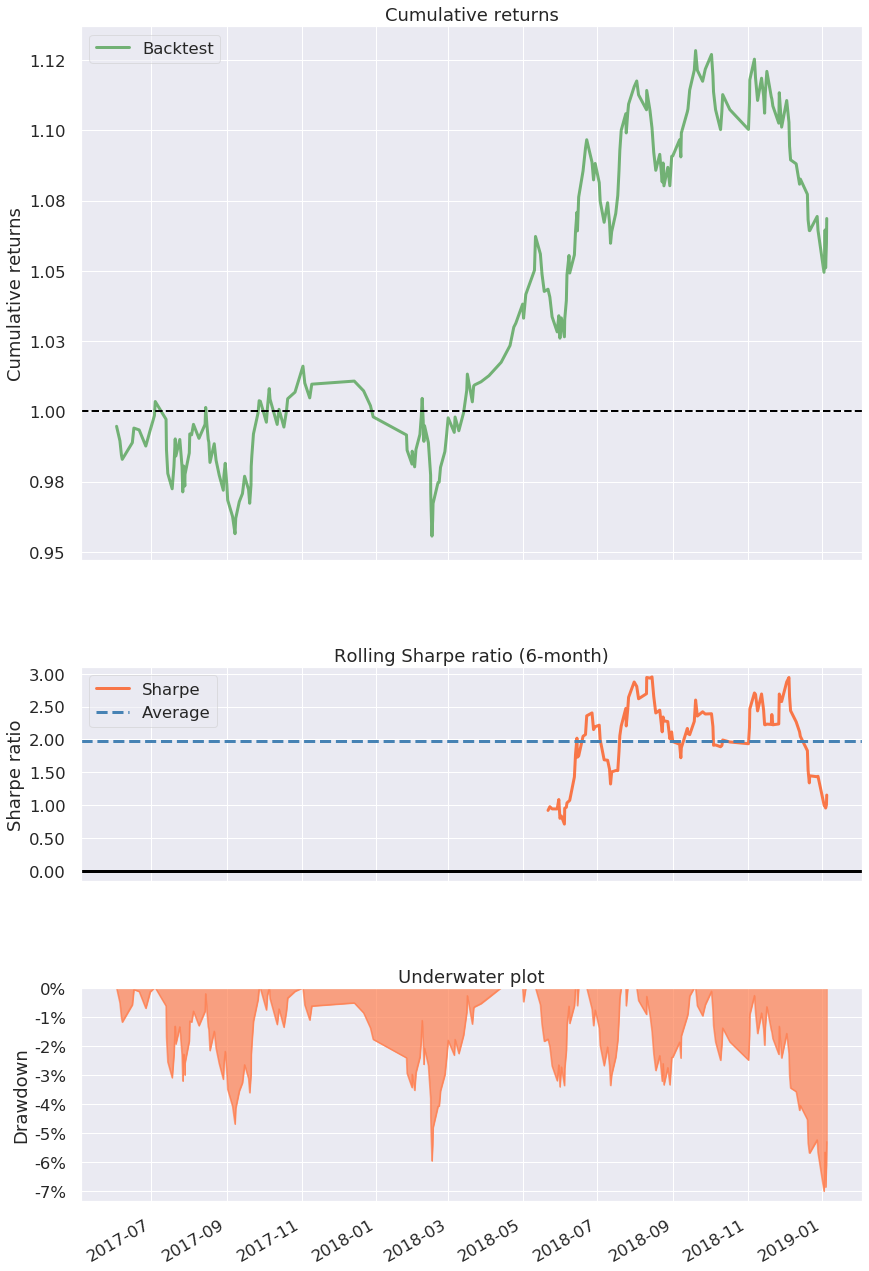

In [39]:
model = 'ExtraTrees'
cols = top_feat
validation = True
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

Start date,2017-06-02
End date,2019-01-04
Total months,11
,Backtest
Annual return,9.2%
Cumulative returns,8.629%
Annual volatility,10.044%
Sharpe ratio,0.93
Calmar ratio,1.55
Stability,0.81
Max drawdown,-5.954%


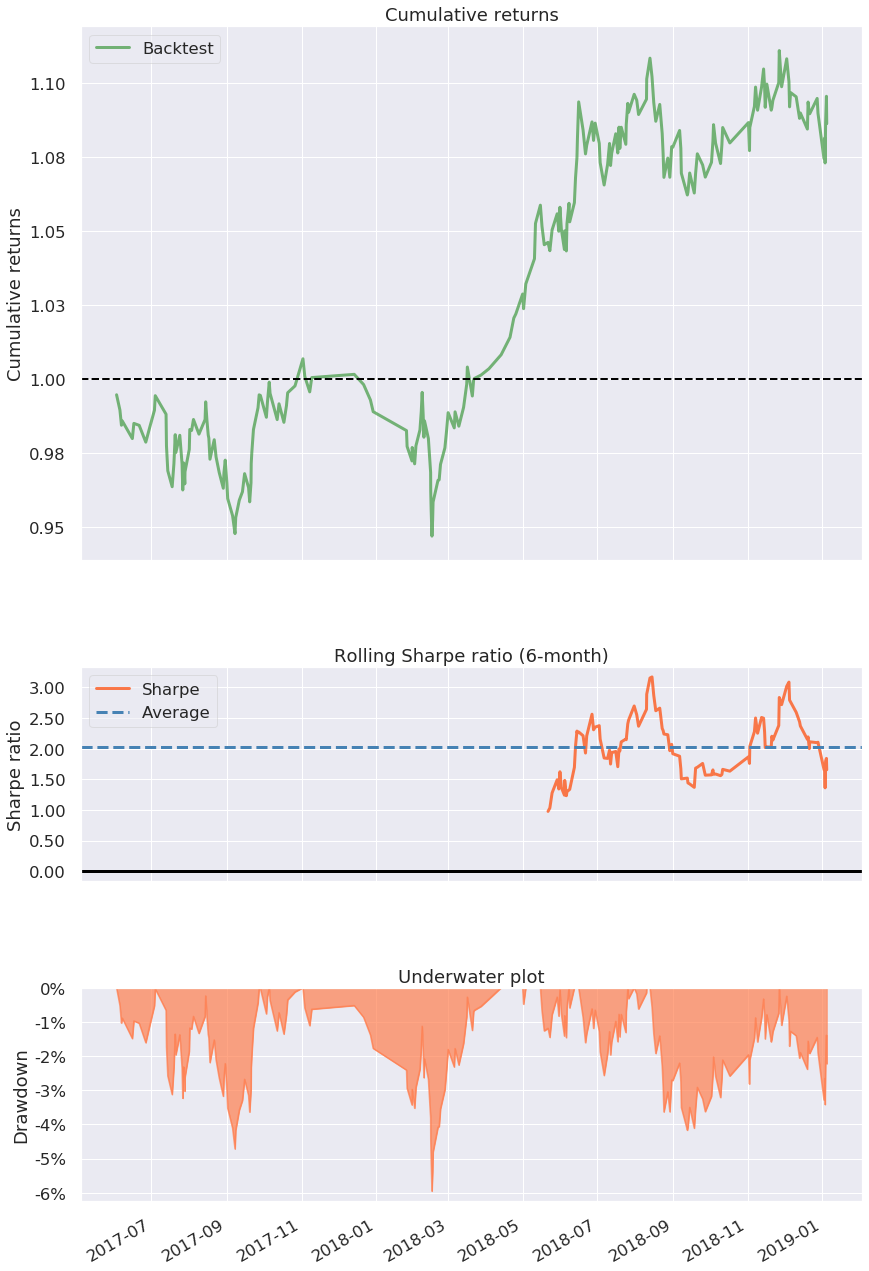

In [40]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = True
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

Start date,2017-06-02
End date,2019-01-04
Total months,11
,Backtest
Annual return,10.299%
Cumulative returns,9.658%
Annual volatility,10.04%
Sharpe ratio,1.03
Calmar ratio,1.73
Stability,0.74
Max drawdown,-5.954%


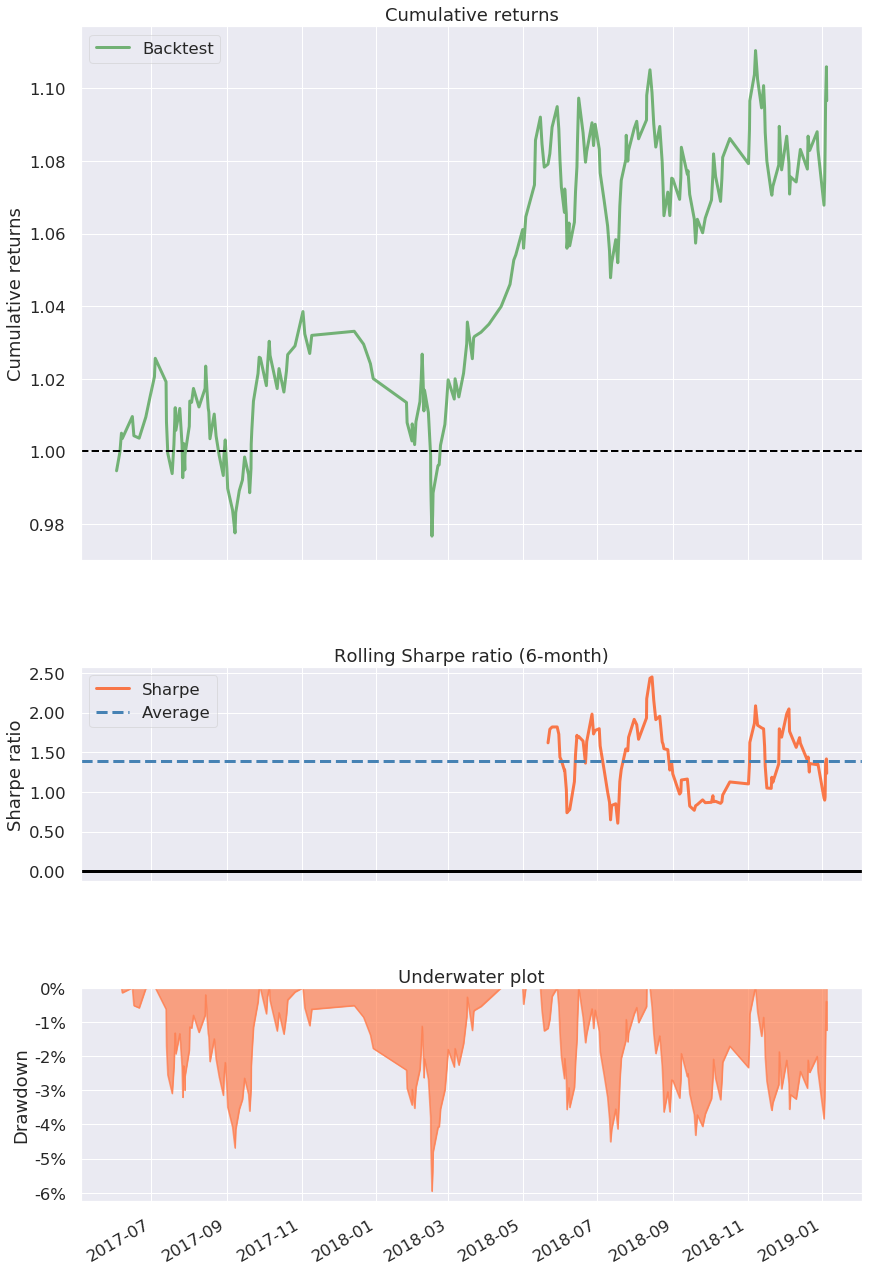

In [41]:
model = 'Scaler->PCA4->SVM'
validation = True
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

Start date,2017-06-02
End date,2019-01-04
Total months,11
,Backtest
Annual return,14.319%
Cumulative returns,13.412%
Annual volatility,10.023%
Sharpe ratio,1.39
Calmar ratio,2.40
Stability,0.81
Max drawdown,-5.954%


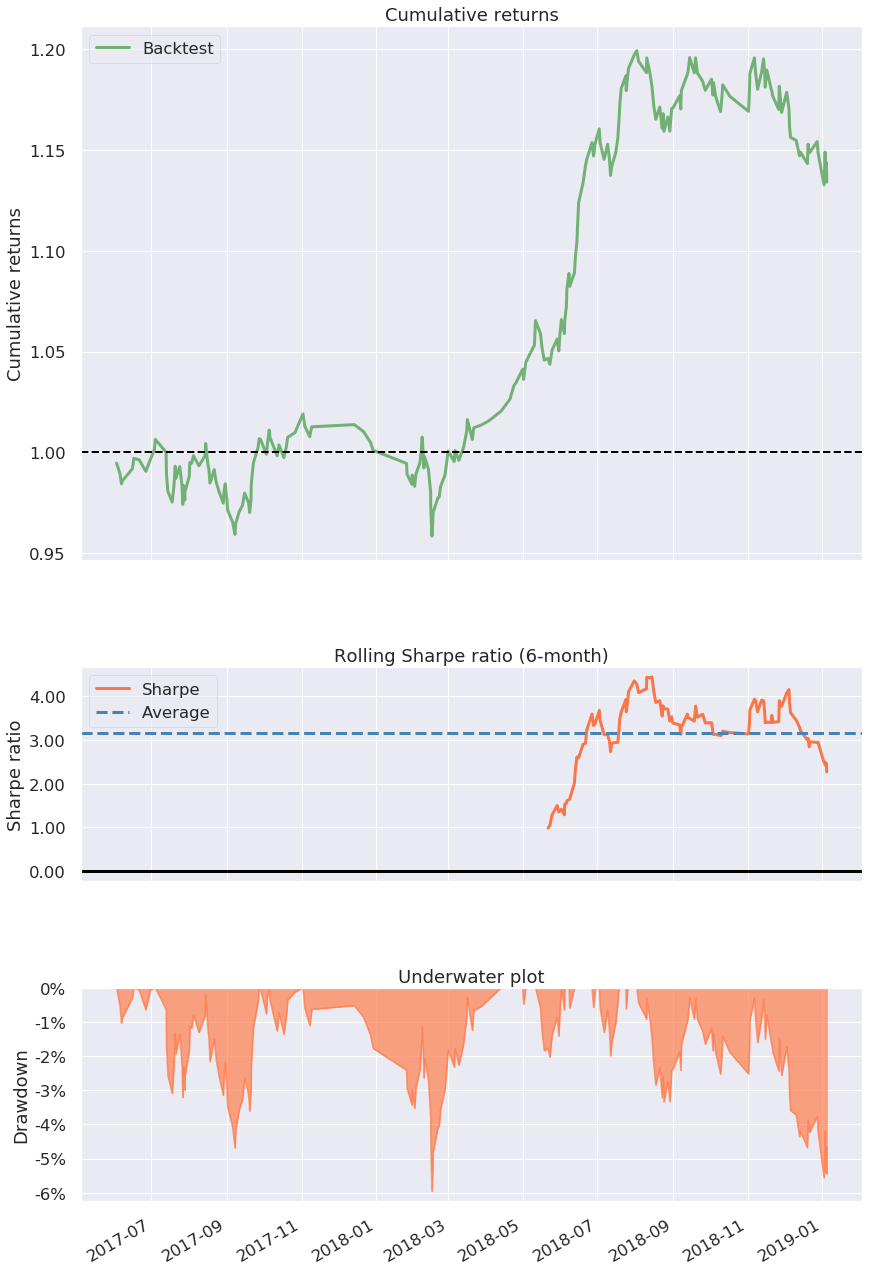

In [80]:
vc = VotingClassifier(estimators=[('RF',models['RF']),
                                  ('ExtraTrees',models['ExtraTrees']),
                                  ('Scaler->PCA4->LogRegr', models['Scaler->PCA4->LogRegr']),
                                  ('Scaler->SVM',models['Scaler->PCA4->SVM'])],
                     voting = 'soft')
vc.fit(X_train[cols], Y_train)
wqu.get_pyfolio_simple_tear_sheet(vc,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)

### Putting it all together

<img src="..\results\AUDUSD_ensemble.png">

So, looking at above, we can see that the voting ensemple of these algorythms performs better than individual algorythms.
It was noted that while some ML algorythms may underperform in certain scenarios, their presence in the ensemple improves overall sharp ratio.

### Final test on the Test set
The test set includes COVID-19 period that had significantly different characteristics.

Start date,2019-01-11
End date,2020-06-19
Total months,11
,Backtest
Annual return,52.819%
Cumulative returns,49.01%
Annual volatility,21.989%
Sharpe ratio,2.04
Calmar ratio,1.75
Stability,0.54
Max drawdown,-30.252%


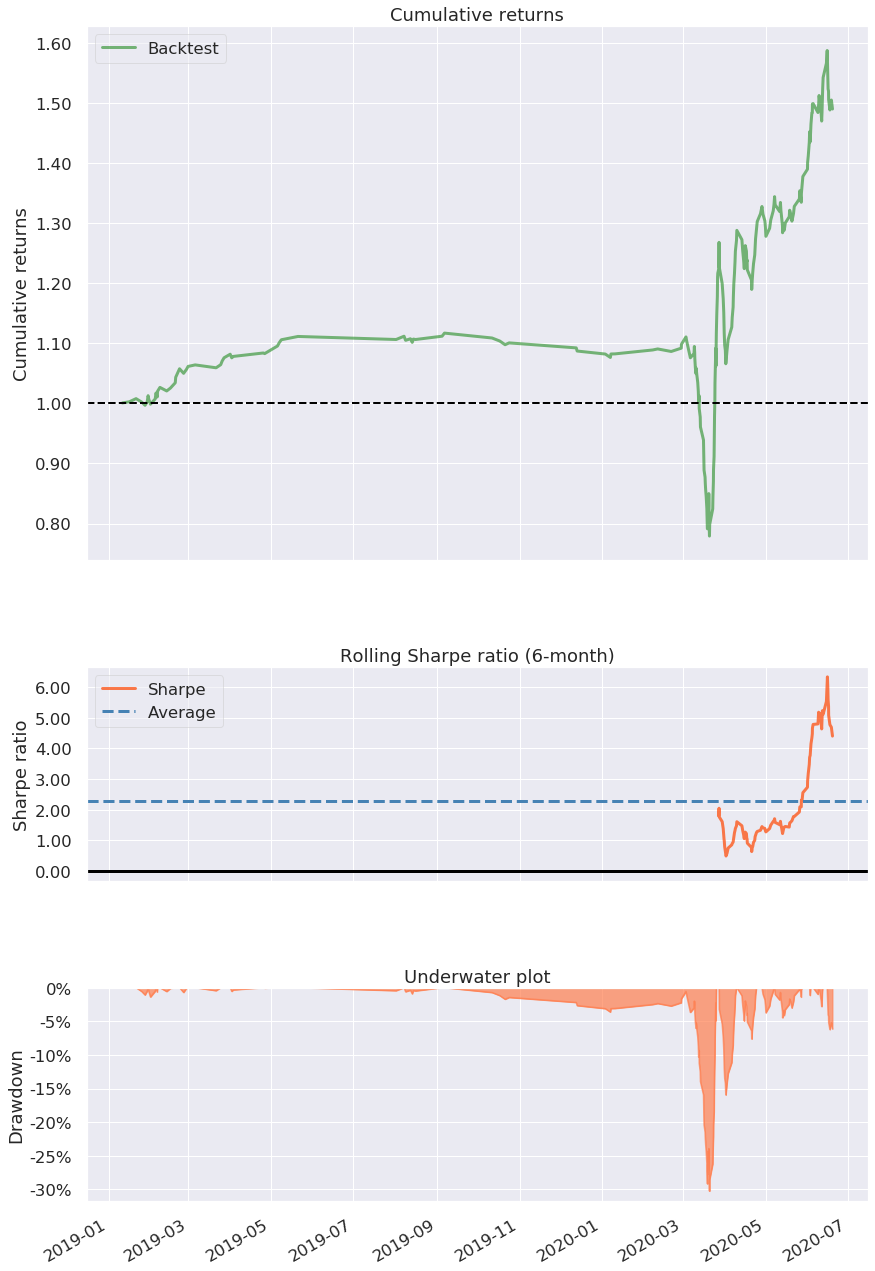

In [81]:
wqu.get_pyfolio_simple_tear_sheet(vc,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

The bad news is that we have a drawdown of 30%, the good news is that the overal performance is +53% in annual terms. 

## Conclusion
We managed to create an ensemble of ML algorythms that has better performance and sharp ration characteristics than individual algorythms. 

### Appendix 1 - Testing all currencies
It is important to note that since results are probabilistic, we should expect negative returns in some cases.
Start/End dates are based on times when trade signals were received for the pair and may differ from each other.
The average performance of the below pairs is 11% in annual terms, which is an acceptable result.
As a further step we may try using different ML on different pairs to improve performance characteristics.

<img src="..\results\AllPairsTest.png">

### Appendix 2 - Code to generate the data from appendix 1

USD/JPY


Start date,2018-02-14
End date,2020-06-17
Total months,9
,Backtest
Annual return,29.75%
Cumulative returns,22.58%
Annual volatility,14.519%
Sharpe ratio,1.87
Calmar ratio,2.23
Stability,0.56
Max drawdown,-13.321%


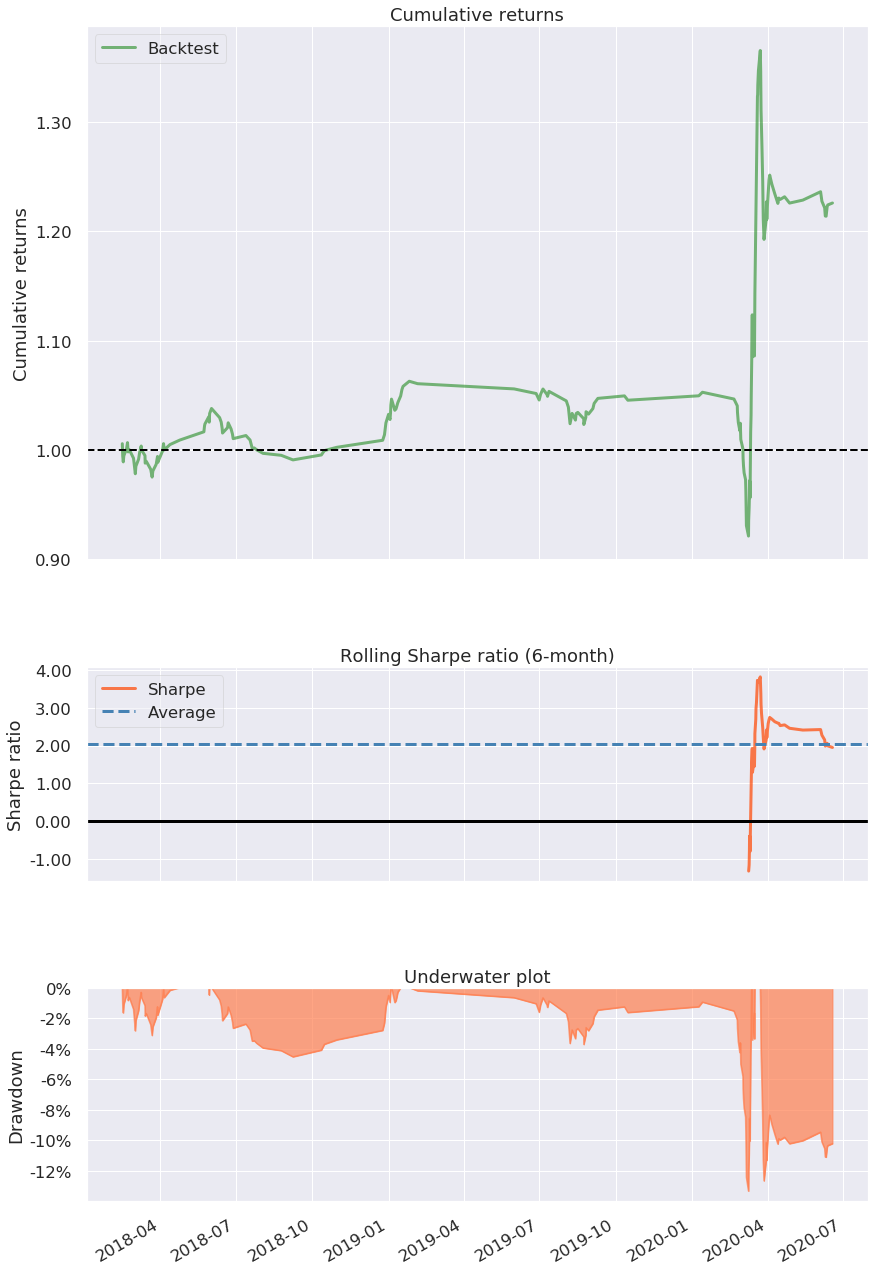

In [84]:
#tickers = ['AUD/USD','AUD/CAD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']
ticker = 'USD/JPY'
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True) 
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')
all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)
vc.fit(X_train[cols], Y_train)
validation = False
print(ticker)
if validation:
    wqu.get_pyfolio_simple_tear_sheet(vc,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(vc,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)